In [1]:
import os
os.environ['PATH']="D:/openslide-win64-20171122/bin"+';'+os.environ['PATH']
import openslide
import xml
import xml.etree.ElementTree as ET
import PIL
import PIL.ImageDraw as ImageDraw
import PIL.Image as Image
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from skimage import measure
from skimage.transform import resize
import numpy as np


import torch
import torch.utils.data as data_utils
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import imageio

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [2]:
class Pathology_Patches(data_utils.Dataset):
    def __init__(self,root_dir_list, patch_shape, tissue, transform):
        self.root_dir_list = root_dir_list
        self.patch_shape = patch_shape
        self.tissue = tissue
        self.transform = transform
        self.path_list = self.get_path()

    def get_path(self):
        path_list = []
        for root_dir in self.root_dir_list:
            sub_dir = os.path.join(root_dir,str(self.patch_shape[0]))
            if self.tissue == 'tumor':
                sub_patch_dir = os.path.join(sub_dir,'tumor/non-blank')
            elif self.tissue == 'stroma':
                sub_patch_dir = os.path.join(sub_dir,'stroma/non-blank')
            else:
                print("Invalid tissue type")
            for path in os.listdir(sub_patch_dir):
                full_path = os.path.join(sub_patch_dir,path)
                if os.path.isfile(full_path):
                    path_list.append(full_path)
        return path_list
    def __len__(self):
        return len(self.path_list)
    def __getitem__(self,index):
        img = imageio.imread(self.path_list[index])
        if self.transform is not None:
            img = self.transform(img)
        return img
        

In [3]:
class Pathology_Bags(data_utils.Dataset):
    def __init__(self, tumor_loader, stroma_loader, num_bag, length_bag, seed):
        self.tumor_loader = tumor_loader
        self.stroma_loader = stroma_loader
        self.num_bag = num_bag
        self.length_bag = length_bag
        self.r = np.random.RandomState(seed)
        self.bags_list, self.labels_list = self._create_bags()
        
    
    def _create_bags(self):
        for patch_idx, patch in enumerate(self.tumor_loader):
            all_tumor_imgs = patch
            #print(all_tumor_imgs.shape)
        for patch_idx, patch in enumerate(self.stroma_loader):
            all_stroma_imgs = patch
            
        bags_list = []
        labels_list = []
        while (len(bags_list)< int(self.num_bag/2)):
            print(len(bags_list))
            indices = torch.LongTensor(self.r.randint(0, all_tumor_imgs.shape[0], self.length_bag))
            #print(indices)
            bags_list.append(all_tumor_imgs[indices])
            labels_list.append(1)
        while (len(bags_list)< self.num_bag):
            print(len(bags_list))
            indices = torch.LongTensor(self.r.randint(0, all_stroma_imgs.shape[0], self.length_bag))
            #print(indices)
            bags_list.append(all_stroma_imgs[indices])
            labels_list.append(0)
        return bags_list, labels_list
    
    def __len__(self):
        return len(self.bags_list)
    
    def __getitem__(self, index):
        bag = self.bags_list[index]
        label = self.labels_list[index]
        return bag, label
        

In [4]:
import random
def prepare_data(args):
    trainval_tumor_set = Pathology_Patches( root_dir_list = args.root_dir_list,
                               patch_shape = args.patch_shape, 
                               tissue = 'tumor',
                               transform = transforms.Compose([transforms.ToTensor(),
                                                               transforms.Normalize((0.777, 0.778, 0.769),
                                                                                  (0.124,0.128,0.128))])
                              )
    trainval_stroma_set = Pathology_Patches( root_dir_list = args.root_dir_list,
                               patch_shape = args.patch_shape, 
                               tissue = 'stroma',
                               transform = transforms.Compose([transforms.ToTensor(),
                                                               transforms.Normalize((0.777, 0.778, 0.769),
                                                                                  (0.124,0.128,0.128))])
                              )


    train_tumor_index = random.sample(range(len(trainval_tumor_set)),k = int(len(trainval_tumor_set)*0.8))
    val_tumor_index = [i for i in range(len(trainval_tumor_set)) if i not in train_tumor_index]
    train_stroma_index = random.sample(range(len(trainval_stroma_set)),k = int(len(trainval_stroma_set)*0.8))
    val_stroma_index = [i for i in range(len(trainval_stroma_set)) if i not in train_stroma_index]

    train_tumor_set = data_utils.Subset(trainval_tumor_set, train_tumor_index )
    val_tumor_set = data_utils.Subset(trainval_tumor_set, val_tumor_index)
    train_stroma_set = data_utils.Subset(trainval_stroma_set, train_stroma_index )
    val_stroma_set = data_utils.Subset(trainval_stroma_set, val_stroma_index)
    
    print("Tumor patches in training set:", len(train_tumor_set))
    print("Stroma patches in training set:",len(train_stroma_set))
    print("Tumor patches in validation set:",len(val_tumor_set))
    print("Stroma patches in validation set:",len(val_stroma_set))
    
    Train_tumor_loader_list = []
    for i in range(1,5):
        fold_size = int(len(train_tumor_set)/4)  
        if i == 4:
            train_tumor_set_fold = data_utils.Subset(train_tumor_set, range(int((i-1)*fold_size),len(train_tumor_set)))
        else:
            train_tumor_set_fold = data_utils.Subset(train_tumor_set, range(int((i-1)*fold_size),int(i*fold_size)))
        print("Fold {}, Tumor patches in sub-training set:{}".format(i,len(train_tumor_set_fold)))
        train_tumor_loader_fold = data_utils.DataLoader(train_tumor_set_fold, batch_size = len(train_tumor_set_fold), 
                                                        shuffle = False)
        Train_tumor_loader_list.append(train_tumor_loader_fold)
                                                        
    Train_stroma_loader_list = []
    for i in range(1,5):
        fold_size = int(len(train_stroma_set)/4)  
        if i == 4:
            train_stroma_set_fold = data_utils.Subset(train_stroma_set, range(int((i-1)*fold_size),len(train_stroma_set)))
        else:
            train_stroma_set_fold = data_utils.Subset(train_stroma_set, range(int((i-1)*fold_size),int(i*fold_size)))
        print("Fold {}, Stroma patches in sub-training set:{}".format(i,len(train_stroma_set_fold)))
        train_stroma_loader_fold = data_utils.DataLoader(train_stroma_set_fold, batch_size = len(train_stroma_set_fold), 
                                                        shuffle = False)
        Train_stroma_loader_list.append(train_stroma_loader_fold)
    
    val_tumor_loader = data_utils.DataLoader(val_tumor_set, batch_size = len(val_tumor_set), shuffle = False)
    val_stroma_loader = data_utils.DataLoader(val_stroma_set, batch_size = len(val_stroma_set), shuffle = False)
    
    return Train_tumor_loader_list, val_tumor_loader, Train_stroma_loader_list, val_stroma_loader


In [5]:
class Attention_188(nn.Module):
    def __init__(self):
        super(Attention_188,self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1
        
        self.dropout = nn.Dropout(p=0.5)

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3,8,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(8,16,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(16,32,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(32,32,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(32 * 8* 8, self.L),
            nn.ReLU()
        )
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = x .squeeze(0)

        H = self.feature_extractor_part1(x)
        #print(H.shape)
        #H = H.view(-1, 60 * 8 * 8)
        H = torch.flatten(H, start_dim =1)
        #print(H.shape)
        H = self.dropout(H)
        #print(H.shape)
        H = self.feature_extractor_part2(H)

        A = self.attention(H)
        A = torch.transpose(A,1,0)
        A = F.softmax(A,dim=1)

        M = torch.mm(A,H)
        M = self.dropout(M)

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob,0.5).float()
        #print(Y_prob.shape, Y_hat.shape)

        return Y_prob, Y_hat, A

    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        Y_prob, Y_hat,_ = self.forward(X)
        #print(Y, Y_hat, Y_hat.eq(Y))
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data.item()

        return error, Y_hat, Y_prob
  
    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood =-1. * (Y * torch.log(Y_prob)+(1. - Y) * torch.log(1. - Y_prob))

        return neg_log_likelihood, A

In [6]:
class Attention_92(nn.Module):
    def __init__(self):
        super(Attention_92,self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1
        
        self.dropout = nn.Dropout(p=0.5)

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3,20,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(20,50,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Conv2d(50,60,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2)
        )
        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(60 * 8* 8, self.L),
            nn.ReLU()
        )
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = x .squeeze(0)

        H = self.feature_extractor_part1(x)
        #print(H.shape)
        #H = H.view(-1, 60 * 8 * 8)
        H = torch.flatten(H, start_dim =1)
        #print(H.shape)
        H = self.dropout(H)
        #print(H.shape)
        H = self.feature_extractor_part2(H)

        A = self.attention(H)
        A = torch.transpose(A,1,0)
        A = F.softmax(A,dim=1)

        M = torch.mm(A,H)
        M = self.dropout(M)

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob,0.5).float()
        #print(Y_prob.shape, Y_hat.shape)

        return Y_prob, Y_hat, A

    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        Y_prob, Y_hat,_ = self.forward(X)
        #print(Y, Y_hat, Y_hat.eq(Y))
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data.item()

        return error, Y_hat, Y_prob
  
    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood =-1. * (Y * torch.log(Y_prob)+(1. - Y) * torch.log(1. - Y_prob))

        return neg_log_likelihood, A

In [7]:
class Attention_44(nn.Module):
    def __init__(self):
        super(Attention_44,self).__init__()
        self.L = 500
        self.D = 128
        self.K = 1
        
        self.dropout = nn.Dropout(p=0.5)

        self.feature_extractor_part1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(16,32,kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
        )
        self.feature_extractor_part2 = nn.Sequential(
            nn.Linear(32 * 8* 8, self.L),
            nn.ReLU()
        )
        self.attention = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh(),
            nn.Linear(self.D, self.K)
        )
        self.classifier = nn.Sequential(
            nn.Linear(self.L * self.K, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        x = x .squeeze(0)

        H = self.feature_extractor_part1(x)
        #print(H.shape)
        #H = H.view(-1, 60 * 8 * 8)
        H = torch.flatten(H, start_dim =1)
        #print(H.shape)
        H = self.dropout(H)
        #print(H.shape)
        H = self.feature_extractor_part2(H)

        A = self.attention(H)
        A = torch.transpose(A,1,0)
        A = F.softmax(A,dim=1)

        M = torch.mm(A,H)
        M = self.dropout(M)

        Y_prob = self.classifier(M)
        Y_hat = torch.ge(Y_prob,0.5).float()
        #print(Y_prob.shape, Y_hat.shape)

        return Y_prob, Y_hat, A

    def calculate_classification_error(self, X, Y):
        Y = Y.float()
        Y_prob, Y_hat,_ = self.forward(X)
        #print(Y, Y_hat, Y_hat.eq(Y))
        error = 1. - Y_hat.eq(Y).cpu().float().mean().data.item()

        return error, Y_hat, Y_prob
  
    def calculate_objective(self, X, Y):
        Y = Y.float()
        Y_prob, _, A = self.forward(X)
        Y_prob = torch.clamp(Y_prob, min=1e-5, max=1. - 1e-5)
        neg_log_likelihood =-1. * (Y * torch.log(Y_prob)+(1. - Y) * torch.log(1. - Y_prob))

        return neg_log_likelihood, A

In [8]:
def train(epoch, loader):
    model.train()
    train_loss = 0.
    train_error = 0.
    for batch_idx, (data, label) in enumerate(loader):
        bag_label = label
        data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data), Variable(bag_label)

        optimizer.zero_grad()
        loss, _ = model.calculate_objective(data, bag_label)
        train_loss += loss.data[0]
        error, _, _ =model.calculate_classification_error(data, bag_label)
        train_error += error
        loss.backward()
        optimizer.step()

    train_loss /= len(loader)
    train_error /= len(loader)
    print('Epoch: {}, Loss: {:.4f}, Train error : {:.4f}'.format(epoch, train_loss.cpu().numpy()[0], train_error))
    return 1 - train_error, train_loss.cpu().numpy()[0]

def test(loader):
    model.eval()
    test_loss = 0.
    test_error = 0.
    Y_probs = []
    Labels = []
    Attention_weights_positive_bags = []
    Attention_weights_negative_bags = []
    for batch_idx, (data, label) in enumerate(loader):
        bag_label = label
        data, bag_label = data.cuda(), bag_label.cuda()
        data, bag_label = Variable(data), Variable(bag_label)
        loss, attention_weights = model.calculate_objective(data, bag_label)
        test_loss += loss.data[0]
        error, predicted_label, Y_prob = model.calculate_classification_error(data, bag_label)
        test_error += error
        Y_probs.append(Y_prob.cpu().data.numpy()[0][0])
        Labels.append(label)
        if label.numpy()[0]==1:
            Attention_weights_positive_bags.extend(attention_weights.cpu().data.numpy()[0].tolist())
        else:
            Attention_weights_negative_bags.extend(attention_weights.cpu().data.numpy()[0].tolist())

    
    test_error /= len(loader)
    test_loss /= len(loader)
    return 1 - test_error, test_loss.cpu().numpy()[0], Y_probs, Labels, Attention_weights_positive_bags, Attention_weights_negative_bags

In [9]:
class Args:
    def __init__(self):
        self.root_dir_list=['D:/Ashel-slide/458599']
        self.patch_shape = (188,188)
        self.model = Attention_188()
        self.num_bag_train = 200
        self.num_bag_val = 200
        self.length_bag = 50
        self.seed = 1   
        self.epochs = 20
        self.lr = 0.0001
        self.reg = 10e-5
args = Args()
loader_kwards = {'num_workers':1, 'pin_memory':True} 
torch.cuda.manual_seed(args.seed)

In [10]:
Train_tumor_loader_list, val_tumor_loader, Train_stroma_loader_list, val_stroma_loader = prepare_data(args)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'D:/Ashel-slide/458603\\188\\tumor/non-blank'

In [11]:
val_set = Pathology_Bags(tumor_loader = val_tumor_loader, 
                           stroma_loader = val_stroma_loader, 
                           num_bag = args.num_bag_val, 
                           length_bag = args.length_bag, 
                           seed = args.seed)
val_loader = data_utils.DataLoader(val_set, batch_size = 1, shuffle = False)

len_negative_bag = 0
len_positive_bag = 0
for bag_idx, (bag, label) in enumerate(val_loader):
    print(bag.shape)
    if label.numpy()[0] == 0:
        len_negative_bag += 1
    else:
        len_positive_bag += 1
print("There are {} positive bags, {} negative bags in validation set".format(len_positive_bag, len_negative_bag))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1, 50, 3, 188, 188])
torch.Size([1

In [12]:
model = args.model
model.cuda()
optimizer = optim.Adam(model.parameters(),lr=args.lr, betas=(0.9, 0.999), weight_decay =args.reg)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size = 10, gamma = 0.5)



Train_accuracy = []
Val_accuracy = []
Loss_train = []
Loss_val = []
Epochs = np.arange(1,args.epochs+1).tolist()
for epoch in range(1,args.epochs+1):  
    train_set = Pathology_Bags(tumor_loader = Train_tumor_loader_list[epoch % 4], 
                           stroma_loader = Train_stroma_loader_list[epoch % 4], 
                           num_bag = args.num_bag_train, 
                           length_bag = args.length_bag, 
                           seed = args.seed)

    train_loader = data_utils.DataLoader(train_set, batch_size = 1, shuffle = True)
    
    train_accuracy, loss_train = train(epoch, train_loader)
    val_accuracy, loss_val, _, _, _, _ = test(val_loader)
    
    print("epoch = {}, accuracy in training set is {}, accuracy in valiation set is {}".format(epoch, train_accuracy, val_accuracy))
    print("epoch = {}, loss in training set is {}, loss in valiation set is {}".format(epoch, loss_train, loss_val))
    Train_accuracy.append(train_accuracy)
    Val_accuracy.append(val_accuracy)
    Loss_train.append(loss_train)
    Loss_val.append(loss_val)
    scheduler.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Epoch: 1, Loss: 0.7008, Train error : 0.4900
epoch = 1, accuracy in training set is 0.51, accuracy in valiation set is 0.5
epoch = 1, loss in training set is 0.7008277177810669, loss in valiation set is 0.693777859210968
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Epoch: 10, Loss: 0.0789, Train error : 0.0150
epoch = 10, accuracy in training set is 0.985, accuracy in valiation set is 0.875
epoch = 10, loss in training set is 0.07894312590360641, loss in valiation set is 0.6432177424430847
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
3

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
Epoch: 19, Loss: 0.2295, Train error : 0.0500
epoch = 19, accuracy in training set is 0.95, accuracy in valiation set is 0.97
epoch = 19, loss in training set is 0.2295074611902237, loss in valiation set is 0.13094334304332733
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


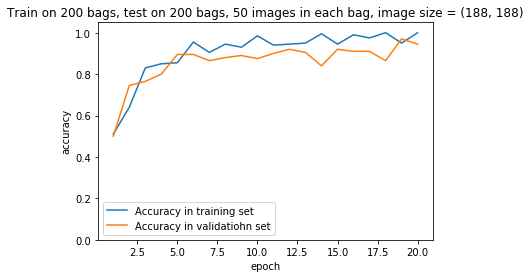

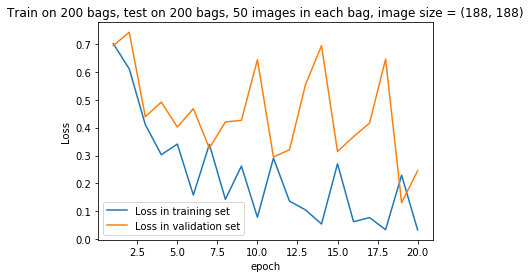

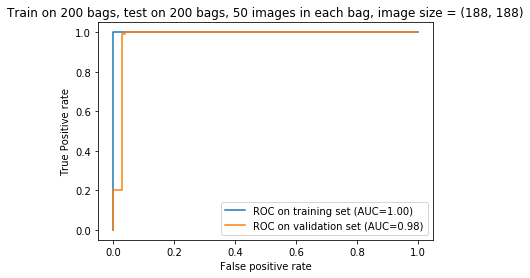

In [13]:
plt.figure()
plt.plot(Epochs, Train_accuracy, label = "Accuracy in training set")
plt.plot(Epochs, Val_accuracy, label = "Accuracy in validatiohn set")
plt.title("Train on {} bags, test on {} bags, {} images in each bag, image size = {}".format(int(args.num_bag_train),
                                                                                             int(args.num_bag_val),
                                                                                               args.length_bag,
                                                                                               args.patch_shape))
plt.ylim([0.0,1.05])
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.figure()
plt.plot(Epochs, Loss_train, label = "Loss in training set")
plt.plot(Epochs, Loss_val, label = "Loss in validation set")
plt.title("Train on {} bags, test on {} bags, {} images in each bag, image size = {}".format(int(args.num_bag_train),
                                                                                             int(args.num_bag_val),
                                                                                               args.length_bag,
                                                                                               args.patch_shape))

plt.xlabel("epoch")
plt.ylabel("Loss")
plt.legend()

train_accuracy, train_loss, train_prob, train_labels, _, _ = test(train_loader)
val_accuracy, val_loss, val_prob, val_labels, _, _ = test(val_loader)
train_auc = roc_auc_score(train_labels, train_prob)
val_auc = roc_auc_score(val_labels, val_prob)
fpr_train, tpr_train, _ = roc_curve(train_labels, train_prob)
fpr_val, tpr_val, _ = roc_curve(val_labels, val_prob)
plt.figure()
plt.plot(fpr_train, tpr_train, label = "ROC on training set (AUC=%.2f)"%train_auc)
plt.plot(fpr_val, tpr_val, label = "ROC on validation set (AUC=%.2f)"%val_auc)
plt.title("Train on {} bags, test on {} bags, {} images in each bag, image size = {}".format(int(args.num_bag_train),
                                                                                             int(args.num_bag_val),
                                                                                               args.length_bag,
                                                                                               args.patch_shape))
plt.xlabel("False positive rate")
plt.ylabel("True Positive rate")
plt.legend()

In [14]:
torch.save(model.state_dict(), "model_188_50.pth")